In [1]:
import scipy.io.wavfile as wav
import numpy as np
import time 
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
%matplotlib inline

from __future__ import division
from sklearn.cross_validation import StratifiedKFold
from sklearn.externals.six.moves import xrange
from sklearn.mixture import GMM
from sklearn.metrics import accuracy_score, classification_report
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix


In [2]:
mfcc_original_train = np.loadtxt('mfcc_original_train.txt')

mfcc_spoof_train = np.loadtxt('mfcc_spoof_train.txt')

mfcc_original_develop = np.loadtxt('mfcc_original_dev.txt')

mfcc_spoof_develop = np.loadtxt('mfcc_spoof_dev.txt')

mfcc_original_test = np.loadtxt('mfcc_original_eva.txt')

mfcc_spoof_test = np.loadtxt('mfcc_spoof_eva.txt')

# Train set

In [4]:
X_train = np.concatenate([mfcc_original_train, mfcc_spoof_train]) 
y_train = np.concatenate([np.zeros((mfcc_original_train.shape[0])), np.ones((mfcc_spoof_train.shape[0]))]).astype('int')

# Development set 

In [5]:
X_develop = np.concatenate([mfcc_original_develop, mfcc_spoof_develop]) 
y_develop = np.concatenate([np.zeros((mfcc_original_develop.shape[0])), np.ones((mfcc_spoof_develop.shape[0]))]).astype('int')


# Test set

In [6]:
X_test = np.concatenate([mfcc_original_test, mfcc_spoof_test]) 
y_test = np.concatenate([np.zeros((mfcc_original_test.shape[0])), np.ones((mfcc_spoof_test.shape[0]))]).astype('int')


# Learn

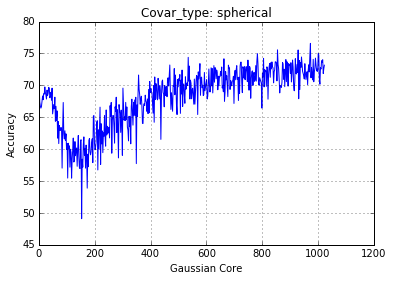

In [7]:
n_g = 1024

for covar_type in ['spherical']:
    number_gaussian = []
    acc = []

    tic = time.time() #Время работы типа ковариации. Старт
    confusion_matrixLog = []
    
    for i in range(1,n_g, 2):
        timeGausStart = time.time()
        
        number_gaussian.append(i) #Число Ядер Гауса
        
        # Обучаем модель оригинальных дикторов на тренировочном наборе

        g1 =  GMM(n_components = i, covariance_type=covar_type, init_params='wc', n_iter=20)
        g1.fit(mfcc_original_train)

        # Обучаем модель голосовых подделок на тренировочном наборе
        g2 =  GMM(n_components = i, covariance_type=covar_type, init_params='wc', n_iter=20)
        g2.fit(mfcc_spoof_train)
        
        # Дообучаем модели

       
        # Дообучаем модель оригинальных дикторов на develop наборе

        #g1.fit(mfcc_original_develop)

        # Дообучаем модель голосовых подделок на develop наборе
        #g2.fit(mfcc_spoof_develop)

        
        prediction  = np.array(np.log(mfcc_original_train.shape[0])+ g1.score(X_test)  < np.log(mfcc_spoof_train.shape[0])+g2.score(X_test)).astype('int')

        accuracy = np.mean(prediction == y_test) * 100
        acc.append(accuracy)

        cm = confusion_matrix(y_test, prediction)   

        confusion_matrixLog.append(cm)
        
        #----Лог для confusion matrix ------
        with open(r'D:\Filin\25.10.16. Next_step\Experiment\ConfusionLog-'+covar_type+'.txt', 'a') as c:
            c.write('\n--------------------\n')
            text =  ('Covar_type: ' +  covar_type + ', number gaussian = ' ,  i)
            c.write(str(text))
            c.write('\nConf_matrix: \n')
            c.write(" ".join(map(str, cm)))
            
        #----Конец -------------------
        
        #-----Accuracy Log --------
        with open(r'D:\Filin\25.10.16. Next_step\Experiment\AccuracyLog-'+covar_type+'.txt', 'a') as al:
            al.write('\n--------------------\n')
            text =  ('Covar_type: ',  covar_type , ', number gaussian' , i)
            al.write(str(text))
            text2 = ( ' Train accuracy: %.1f' % accuracy)
            al.write(str(text2))
 
        timeGausEnd = time.time()
        timeGausWork = timeGausEnd - timeGausStart
        
        #Лог для времени работы количества ядер
        with open(r'D:\Filin\25.10.16. Next_step\Experiment\LogCoreTime-'+covar_type+'.txt', 'a') as t:
            text =  ('Covar_type: ',  covar_type , ', number gaussian' , i, 'time = ', timeGausWork)
            t.write('\n--------------------\n')
            t.write(str(text))
    toc = time.time()# Окончание работы типа ковариации
    time_covartype = toc -tic
    
    
        
    #------Лог для типа ковариации -----------
    f = open (r'D:\Filin\25.10.16. Next_step\Experiment\TimeLog-'+covar_type+'.txt', 'a')
    text =  ('Covar_type: ',  covar_type , ', time = ', time_covartype, '\n')
    f.write('\n--------------------\n')
    f.write(str(text))
    #----------------------------------------
  
    plt.figure()
    plt.title('Covar_type: ' + covar_type)
    tr_a = plt.plot(number_gaussian,acc,color = 'b')

    plt.xlabel('Gaussian Core')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
